[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ee-ortiz/ISIS-4825_202510_IMAGENES_Y_VISION/blob/main/Laboratorio_07/Practica/MISIS4825-Laboratorio07-Practica.ipynb)

![image](https://drive.google.com/u/0/uc?id=15DUc09hFGqR8qcpYiN1OajRNaASmiL6d&export=download)

# Redes Neuronales Convolucionales – Conceptos

## Objetivos

- Entender los fundamentos y la arquitectura de las redes neuronales convolucionales (CNN).
- Implementar una red convolucional simple para tareas de clasificación de imágenes.
- Conocer el funcionamiento de capas clave: Conv2D, Pooling, Dropout, Flatten y Dense.
- Entrenar y evaluar el modelo, analizando el impacto de cada componente.

## Contexto

Las redes neuronales convolucionales se utilizan ampliamente en tareas de visión artificial, ya que son capaces de extraer automáticamente características relevantes de las imágenes. En este laboratorio trabajaremos con el conjunto de datos **American Sign Language Dataset** para clasificar imágenes de lenguaje de señas.

**Datos:** [American Sign Language Dataset](https://www.kaggle.com/datasets/ayuraj/asl-dataset)


## 1. Descarga y Preparación del Dataset de Kaggle

En esta sección se descargará el dataset utilizando la API de Kaggle. Se asume que se cuenta con el archivo `kaggle.json` con las credenciales necesarias.

In [1]:
import json
import os
import shutil

In [2]:
# Instalación de Kaggle (si no está instalado)
!pip install kaggle --quiet

In [3]:
# Cargar credenciales desde kaggle.json
with open('./kaggle.json') as f:
    kaggle_credentials = json.load(f)

os.environ['KAGGLE_USERNAME'] = kaggle_credentials['username']
os.environ['KAGGLE_KEY'] = kaggle_credentials['key']

# Autenticar y descargar el dataset
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
api.dataset_download_files('ayuraj/asl-dataset', path='data', unzip=True)

# Eliminar carpeta redundante si existe
redundant_folder_path = 'data/asl_dataset/asl_dataset'
if os.path.exists(redundant_folder_path):
    shutil.rmtree(redundant_folder_path)

Dataset URL: https://www.kaggle.com/datasets/ayuraj/asl-dataset


## 2. Exploración de Datos

Se cargan y visualizan algunas imágenes del dataset para conocer la variedad y distribución de las clases. Se muestra una imagen representativa de cada categoría.

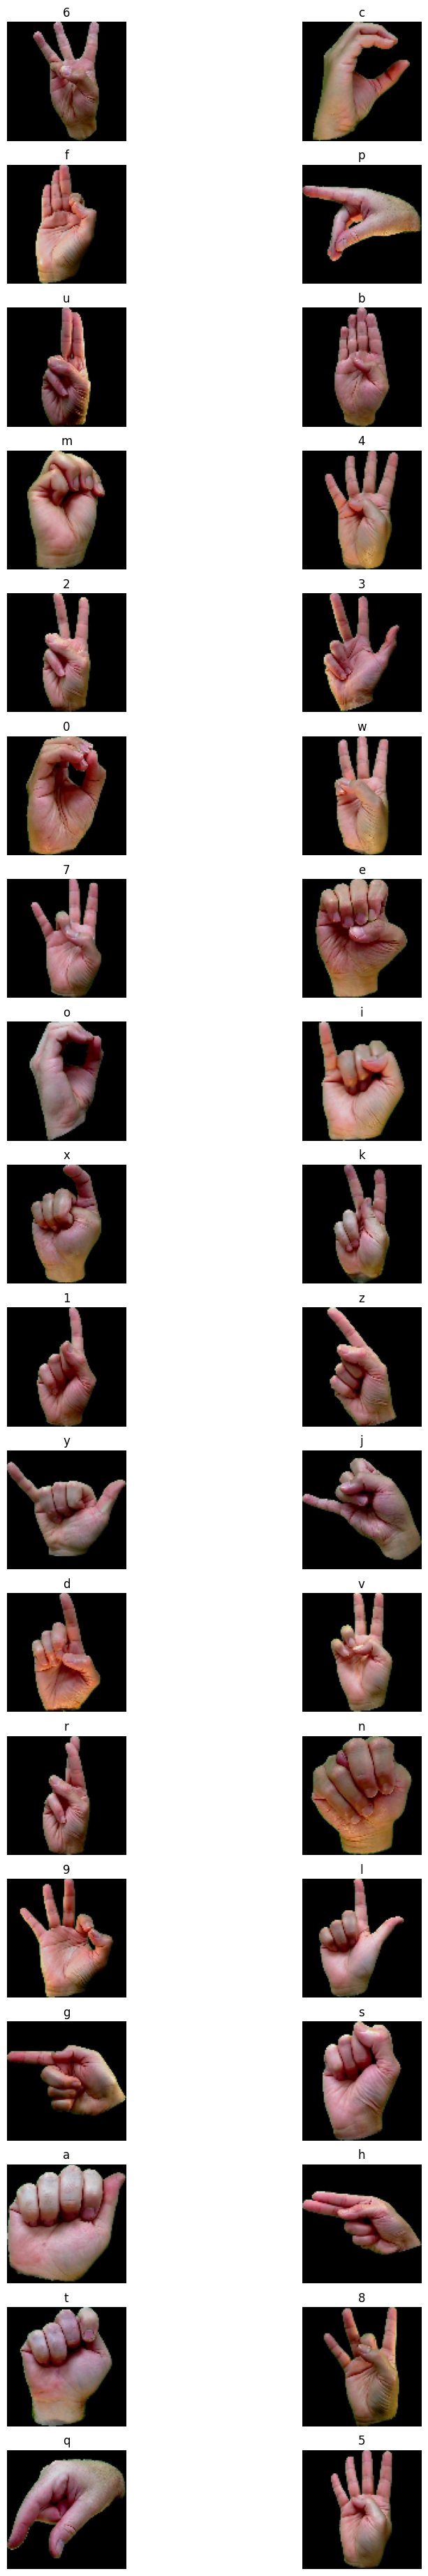

Total de imágenes: 2515
Número de imágenes por categoría:
6: 70
c: 70
f: 70
p: 70
u: 70
b: 70
m: 70
4: 70
2: 70
3: 70
0: 70
w: 70
7: 70
e: 70
o: 70
i: 70
x: 70
k: 70
1: 70
z: 70
y: 70
j: 70
d: 70
v: 70
r: 70
n: 70
9: 70
l: 70
g: 70
s: 70
a: 70
h: 70
t: 65
8: 70
q: 70
5: 70


In [4]:
import matplotlib.pyplot as plt
from tensorflow import keras
import os

# Directorio de datos y obtención de las categorías
data_dir = 'data/asl_dataset'
asl_categories = os.listdir(data_dir)

# Visualización de una imagen de cada categoría
plt.figure(figsize=(10, 50))
for i, category in enumerate(asl_categories):
    folder = os.path.join(data_dir, category)
    image_file = os.listdir(folder)[0]
    img_path = os.path.join(folder, image_file)
    img = keras.preprocessing.image.load_img(img_path, target_size=(100, 100))
    plt.subplot(int(len(asl_categories)/2) + 1, 2, i+1)
    plt.title(category)
    plt.imshow(img)
    plt.axis('off')
plt.show()

# Análisis del tamaño y distribución de clases
image_count = {}
total_images = 0
for category in asl_categories:
    folder = os.path.join(data_dir, category)
    count = len(os.listdir(folder))
    image_count[category] = count
    total_images += count

print(f"Total de imágenes: {total_images}")
print("Número de imágenes por categoría:")
for category, count in image_count.items():
    print(f"{category}: {count}")

## 3. Preprocesamiento de Datos

Se crea un DataFrame con las rutas de los archivos y sus etiquetas (la etiqueta se infiere del nombre de la carpeta). Luego, se dividen los datos en conjuntos de entrenamiento, validación y test.

**Nota:** En este laboratorio no se aplican transformaciones complejas (como ecualización de histograma o filtros), sino que solo se reescala la imagen. En la discusión se analizará qué efectos podría tener aplicar técnicas adicionales de preprocesamiento.

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import os

# Recopilación de rutas y etiquetas
filepaths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(data_dir)
             for f in filenames if os.path.splitext(f)[1].lower() in ['.png','.jpg','.jpeg']]
labels = [os.path.split(os.path.split(path)[0])[1] for path in filepaths]

# Crear DataFrame
data_df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Dividir en entrenamiento (70%), validación (20%) y test (10%)
train_df, test_val_df = train_test_split(data_df, test_size=0.3, random_state=13)
test_df, val_df = train_test_split(test_val_df, test_size=2/3, random_state=13)

print("Total de imágenes:", len(data_df))
print("Entrenamiento:", len(train_df))
print("Validación:", len(val_df))
print("Test:", len(test_df))

Total de imágenes: 2515
Entrenamiento: 1760
Validación: 504
Test: 251


## 4. Generadores de Imágenes

Se utilizan los generadores de datos de Keras para cargar las imágenes en tiempo real.

- Para el conjunto de entrenamiento se aplica data augmentation (rotación, volteo) para mejorar la robustez del modelo.
- Para validación y test, solo se reescala la imagen.

In [6]:
from tensorflow import keras

# Generador para entrenamiento con data augmentation
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=True
)

# Generador para validación y test (solo reescala)
test_val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Creación de generadores a partir de los DataFrames
train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=(100, 100), batch_size=32
)
val_gen = test_val_datagen.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label',
    target_size=(100, 100), batch_size=32, shuffle=False
)
test_gen = test_val_datagen.flow_from_dataframe(
    test_df, x_col='filepath', y_col='label',
    target_size=(100, 100), batch_size=32, shuffle=False
)

Found 1760 validated image filenames belonging to 36 classes.
Found 504 validated image filenames belonging to 36 classes.
Found 251 validated image filenames belonging to 36 classes.


## 5. Construcción del Modelo de Red Convolucional

Se implementa una red neuronal convolucional simple con las siguientes capas:

- **Conv2D:** Aplica filtros aprendibles para extraer características de la imagen.
- **Pooling (MaxPooling2D):** Reduce la dimensión espacial, ayudando a la invariancia a traslaciones y reduciendo el cómputo. Existen otros tipos de pooling que también pueden implementar en la arquitectura como AveragePooling2D, GlobalMaxPooling2D y GlobalAveragePooling2D.
- **Flatten:** Convierte la salida multidimensional en un vector unidimensional.
- **Dense:** Capas completamente conectadas para la clasificación.
- **Dropout:** Regularización para prevenir el sobreajuste.

Cada componente se explica en el código para facilitar su comprensión.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Construcción del modelo CNN
model = Sequential([
    # Primera capa convolucional: extrae características básicas
    Conv2D(16, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D((2, 2)),

    # Segunda capa convolucional: extrae características más complejas
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Aplanamiento para conectar con las capas densas
    Flatten(),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(len(asl_categories), activation='softmax')  # Capa de salida para clasificación
])

# Resumen del modelo para verificar la arquitectura
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 98, 98, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 49, 49, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 47, 47, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16928)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │         270,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 36)                  │             612 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 276,564 (1.06 MB)

 Trainable params: 276,564 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Compilación del Modelo

Se compila el modelo definiendo el optimizador, la función de pérdida y la métrica de evaluación. Utilizamos el optimizador **adam** y la función de pérdida **categorical_crossentropy** adecuada para clasificación multiclase.

In [8]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## 7. Definición de Callbacks

Se utilizan callbacks para:

- **ModelCheckpoint:** Guardar el modelo que presente la menor pérdida en validación.
- **EarlyStopping:** Detener el entrenamiento si la métrica de validación no mejora.
- **ReduceLROnPlateau:** Reducir la tasa de aprendizaje cuando la métrica se estabiliza.

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True,
                                   monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='min')

callbacks = [model_checkpoint, early_stopping, reduce_lr]

## 8. Entrenamiento del Modelo

Se entrena la red convolucional utilizando el conjunto de entrenamiento y se valida con el de validación. Se recomienda experimentar modificando el número de épocas para observar el comportamiento del entrenamiento.

In [10]:
import tensorflow as tf

with tf.device('/device:GPU:0'):
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=50,
        callbacks=callbacks
    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 26s 366ms/step - accuracy: 0.0609 - loss: 3.5160 - val_accuracy: 0.1151 - val_loss: 3.2056 - learning_rate: 0.0010
Epoch 2/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 45s 457ms/step - accuracy: 0.1104 - loss: 3.1480 - val_accuracy: 0.2044 - val_loss: 2.5622 - learning_rate: 0.0010
Epoch 3/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 23s 412ms/step - accuracy: 0.1959 - loss: 2.7110 - val_accuracy: 0.3948 - val_loss: 2.0762 - learning_rate: 0.0010
Epoch 4/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 336ms/step - accuracy: 0.2951 - loss: 2.3422 - val_accuracy: 0.5000 - val_loss: 1.7199 - learning_rate: 0.0010
Epoch 5/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 350ms/step - accuracy: 0.3714 - loss: 2.0476 - val_accuracy: 0.5516 - val_loss: 1.5595 - learning_rate: 0.0010
Epoch 6/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 18s 330ms/step - accuracy: 0.4390 - loss: 1.8991 - val_accuracy: 0.6151 - val_loss: 1.3547 - learning_rate: 0.0010
Epoch 7/50
55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 335ms/step - accuracy: 0.4622 - loss: 1.

## 9. Evaluación del Modelo

Se evalúa el desempeño del modelo utilizando:

- Las curvas de precisión y pérdida durante el entrenamiento.
- La matriz de confusión.
- El reporte de clasificación.

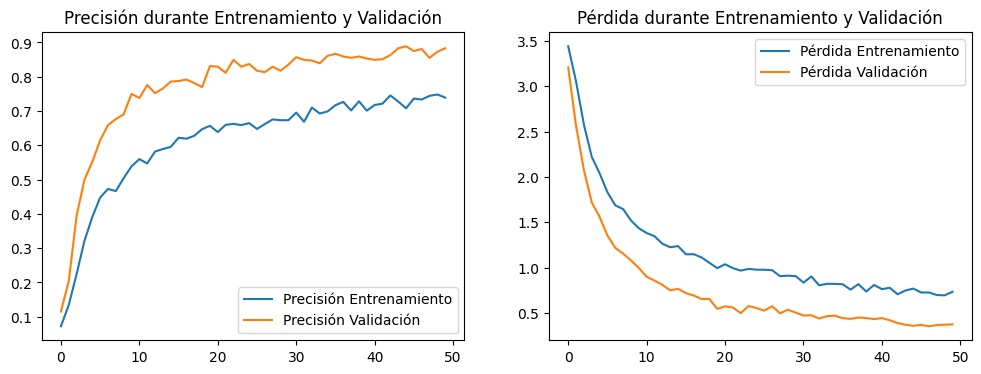

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step


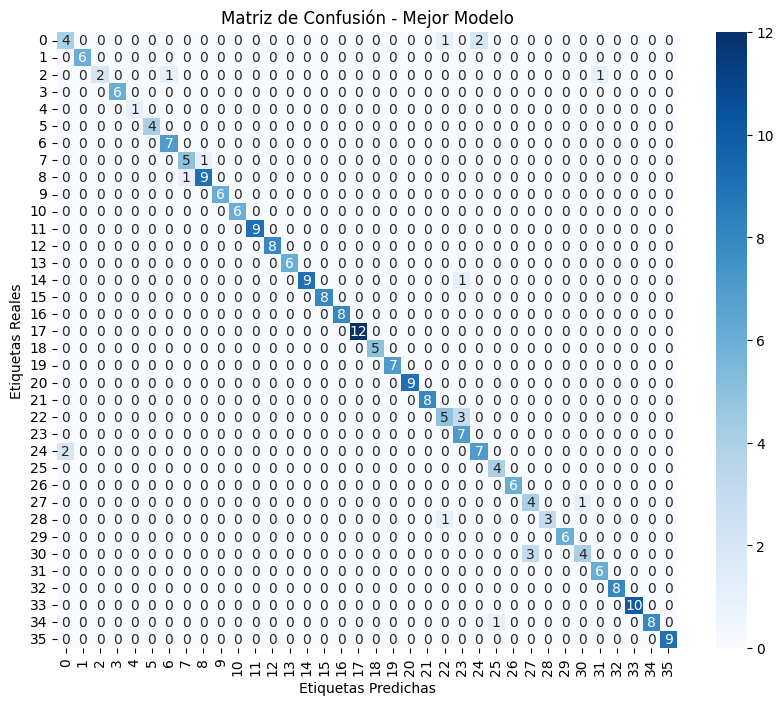

              precision    recall  f1-score   support

           6       0.67      0.57      0.62         7
           c       1.00      1.00      1.00         6
           f       1.00      0.50      0.67         4
           p       1.00      1.00      1.00         6
           u       1.00      1.00      1.00         1
           b       1.00      1.00      1.00         4
           m       0.88      1.00      0.93         7
           4       0.83      0.83      0.83         6
           2       0.90      0.90      0.90        10
           3       1.00      1.00      1.00         6
           0       1.00      1.00      1.00         6
           w       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         8
           e       1.00      1.00      1.00         6
           o       1.00      0.90      0.95        10
           i       1.00      1.00      1.00         8
           x       1.00      1.00      1.00         8
           k       1.00    

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.models import load_model

# Visualización de la evolución del entrenamiento
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Precisión Entrenamiento')
plt.plot(epochs_range, val_acc, label='Precisión Validación')
plt.legend(loc='lower right')
plt.title('Precisión durante Entrenamiento y Validación')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Pérdida Entrenamiento')
plt.plot(epochs_range, val_loss, label='Pérdida Validación')
plt.legend(loc='upper right')
plt.title('Pérdida durante Entrenamiento y Validación')
plt.show()

# Cargar el modelo guardado con el mejor desempeño en validación
best_model = load_model('best_model.keras')

# Evaluar el modelo en el conjunto de test
test_gen.reset()
predicciones = best_model.predict(test_gen, verbose=1)
y_pred = np.argmax(predicciones, axis=1)
y_test = test_gen.classes

# Calcular y mostrar la matriz de confusión y el reporte de clasificación
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues)
plt.title('Matriz de Confusión - Mejor Modelo')
plt.ylabel('Etiquetas Reales')
plt.xlabel('Etiquetas Predichas')
plt.show()

print(classification_report(y_test, y_pred, target_names=asl_categories, zero_division=0))

## 10. Conclusiones y Discusión

- **¿Cómo afecta el tamaño del filtro en las capas convolucionales al rendimiento del modelo?**  
  Analizar cómo el tamaño del filtro influye en la capacidad del modelo para capturar características locales o globales y su impacto en el tiempo de entrenamiento.

- **¿Qué ventajas y desventajas presentan las diferentes estrategias de pooling (MaxPooling, AveragePooling, GlobalPooling) en la extracción de características?**  
  Discutir cómo cada tipo de pooling afecta la preservación de información y la reducción de dimensionalidad.

- **¿Cómo influye la profundidad de la red (número de capas convolucionales) en la capacidad de generalización y el riesgo de sobreajuste?**  
  Reflexionar sobre el balance entre una red más profunda y la necesidad de regularización para evitar el sobreajuste.

- **¿Qué impacto tiene el uso de técnicas como Dropout o Batch Normalization en el entrenamiento de redes convolucionales?**  
  Explorar cómo estas técnicas contribuyen a la estabilidad del entrenamiento y a la mejora del rendimiento general del modelo.